# Pytorch MNIST (hello world) Neural Net

This project shows the basics of building a PyTorch Neural Net. Training, saving, loading a model and using cuda.

In [21]:
import torch 
import torch.nn as nn
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torchvision.datasets as datasets 
from torchvision import transforms 

from time import time
import collections
from collections import OrderedDict
import matplotlib.pyplot as plt

from tqdm import tnrange, tqdm_notebook

print("PyTorch version: " + torch.__version__)

PyTorch version: 1.0.1.post2


In [26]:
# Hyper Parameters  
input_size = 784
hidden_sizes = [512, 128]
output_size = 10
num_classes = 10
image_size=28*28
learning_rate = 0.001
batch_size = 64

# Process the data via torch pipeline

In [27]:
# Transform to a tensor only 
transform = transforms.ToTensor()
# or normalize the values 
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])

# Apply the transform and resize the images to 28x28
transform1 = transforms.Compose([transforms.Resize((28,28)), transforms.ToTensor()])

# Save a copy of the data locally so as not to abuse PyTorch downloads
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [28]:
# Setup torach Input Pipline iterator for batch processing 
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [29]:
class MNIST_DEEP(nn.Module):
    def __init__(self,image_size, hidden_sizes, output_size):
        super(MNIST_DEEP, self).__init__()
        self.image_size = image_size
        # First layer
        self.layer1 = nn.Sequential()
        self.layer1.add_module("Linear1", nn.Linear(self.image_size, hidden_sizes[0]))
        self.layer1.add_module("ReLU1", nn.ReLU(inplace=False))
        
        # Second layer 
        self.layer2 = nn.Sequential(OrderedDict([
            ('Linear2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
            ('ReLU2', nn.ReLU(inplace=False))
        ]))
        self.layer3 = nn.Sequential(OrderedDict([
            ('Linear3', nn.Linear(hidden_sizes[1], output_size)),
            ('ReLU3', nn.LogSoftmax(dim=1))
        ]))
        
      
    def forward(self, x):
        # Flatten the image tensor to 1x784
        x = x.view(-1, self.image_size)
        # Apply each layer to the incoming data 
        # The F.relu is the activation function 
        x = self.layer1(x)
        x = self.layer2(x)
        return self.layer3(x)
    
    
    def train_model(self, epochs):
        time0 = time()
        for epoch in tnrange(1, epochs+1, desc='Epoch '):
            running_loss = 0
            for i, (images, labels) in enumerate(tqdm_notebook(train_loader, desc='Step', leave=False)):
                if torch.cuda.is_available():
                    images = images.cuda()
                    labels = labels.cuda()
                # Flatten MNIST images into a 784 long vector
                images = images.view(images.shape[0], -1)

                # Training pass
                optimizer.zero_grad()

                output = model(images)
                # Compute the loss 
                loss = criterion(output, labels)

                # Backpropagation
                loss.backward()

                # Optimize the weights 
                optimizer.step()

                running_loss += loss.item()
                #if (i + 1) % 100 == 0:
                #    print('Epoch: [% d/% d], Step: [% d/% d], Loss: %.4f'
                #          % (epoch + 1, epochs, i + 1, 
                #             len(mnist_trainset) // batch_size, loss.item())) 
            else:
                print("Epoch {} - Training loss: {}".format(epoch, running_loss/len(train_loader)))


        print("\nTraining Time (in minutes) = {:.2f}".format((time()-time0)/60))
        

In [30]:
model = MNIST_DEEP(image_size, hidden_sizes, output_size)
if torch.cuda.is_available():
    model = model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
model.train_model(10)

Epoch 1 - Training loss: 0.3057038386795185


Epoch 2 - Training loss: 0.14054959807505232


Epoch 3 - Training loss: 0.10003434041135711


Epoch 4 - Training loss: 0.08417328665202269


Epoch 5 - Training loss: 0.07094038072040182


Epoch 6 - Training loss: 0.06277871079112925


Epoch 7 - Training loss: 0.0547612123562446


Epoch 8 - Training loss: 0.04715741393819098


Epoch 9 - Training loss: 0.046827063879813814


Epoch 10 - Training loss: 0.0389970497145734


Training Time (in minutes) = 3.05


In [33]:
correct = 0
total = 0
for images, labels in test_loader:
    images = images.view(-1, 28 * 28)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

    
print('Accuracy of the model on the 10000 test images: % d %%' % (100 * correct / total))

Accuracy of the model on the 10000 test images:  97 %


# Save the model 

In [34]:
torch.save(model.state_dict(), 'mnist.pt')

## Show a batch of the images

In [35]:
def print_batch(images):
    figure = plt.figure()
    num_of_images = 60
    for index in range(1, num_of_images + 1):
        plt.subplot(6, 10, index)
        plt.axis('off')
        plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

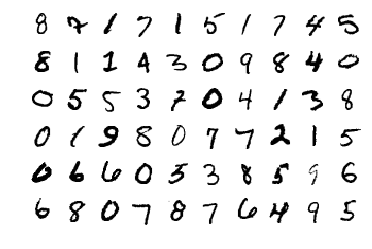

In [36]:
images, labels = next(iter(test_loader))
print_batch(images)

Predicted: 5
Actual: 5


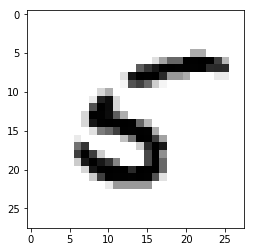

In [37]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

images = images.view(images.shape[0], -1)

probs = model(images)
predicted = probs[0].argmax()
predicted = int(predicted)
print("Predicted: " + str(predicted))
actual = int(labels[0])
print("Actual: " + str(actual))

# Work with new images

These new images I drew.

## Use the PIL library to manipulate the images

In [38]:
from PIL import Image
from PIL import ImageOps
import numpy as np

# Read and Predict

Predicted: tensor(3)


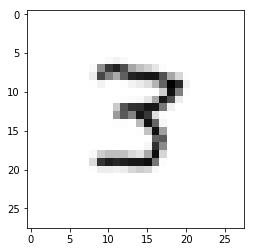

In [39]:
png = Image.open("./images/three.png").convert('L')

img = transform1(png)
plt.imshow(img.numpy().squeeze(), cmap='gray_r')

img = img.view(-1)
probs = model(img)
print("Predicted: " + str(probs.argmax()))

In [40]:
import os
images = [] 
images += [each for each in os.listdir('./images/') if each.endswith('.png')]

numbers = {'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five':5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9}
correct = 0
num_predicted = 0
for i, file in enumerate(images):
    image = Image.open('./images/' + file).convert('L')
    print(file)
    # Get the name of the file and use this to compare to the predicted value.
    actual = os.path.splitext(file)[0]

    img = transform1(image)

    img = img.view(-1)
    
    probs = model(img)
    
    # Get the value out of the tensor     
    probs_value = probs.argmax().item()

    print('Predicted: ' + str(probs_value))

    print('Actual: ' + str(numbers[actual]), end='\n\n')
    # Keep track of how many we got correct 
    correct += 1 if numbers[actual] == probs_value else 0
    num_predicted += 1
    
print(correct)
print('Percent correct: ' + str(round(correct/num_predicted*100)) + '%')

zero.png
Predicted: 0
Actual: 0

seven.png
Predicted: 1
Actual: 7

four.png
Predicted: 4
Actual: 4

six.png
Predicted: 5
Actual: 6

one.png
Predicted: 1
Actual: 1

two.png
Predicted: 2
Actual: 2

five.png
Predicted: 5
Actual: 5

eight.png
Predicted: 3
Actual: 8

three.png
Predicted: 3
Actual: 3

nine.png
Predicted: 3
Actual: 9

6
Percent correct: 60%
